# Проект: "Определение возраста покупателей"

__Описание проекта:__  
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.  

__Задание:__  
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

__План работ:__  
* Провести исследовательский анализ набора фотографий: оценить распределение людей по возрастам, оценить характер фотографий.  
* Подготовить данные к обучению.
* Обучить нейронную сеть и рассчитать её качество.

## Исследовательский анализ данных

In [60]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [53]:
print(f"Число уникальных значений={len(labels['real_age'].unique())}.", 'Примеры значений:', *labels['real_age'][:10])

Число уникальных значений=97. Примеры значений: 4 18 80 50 17 27 24 43 26 39


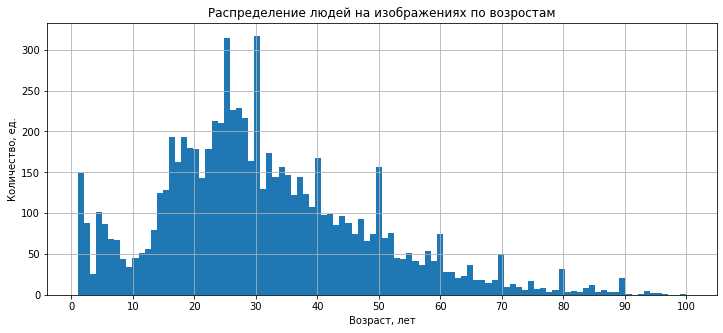

In [74]:
figure, axes = plt.subplots(figsize=(12,5))
axes.hist(labels['real_age'], bins=100)
axes.xaxis.set_major_locator(MultipleLocator(base=10))
plt.title('Распределение людей на изображениях по возростам')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество, ед.')
axes.grid()
plt.show()

__Особенности распределения:__  
На большинстве "круглых" датах наблюдаются пики. Это позволяет говорить о том, что часть данных была размечена на основании не реального, а предполагаемого возраста субъектов. В отношении молодых людей также часто в качестве предполагаемого возраста указывается значение 25 лет - и на графике мы видим пик в этой области. Это является еще одним подтверждением приблизительной разметки датасета.  
Для детей и подростков возраст указан точнее - здесь внешние различия между группами проявляются более явно.  
На графике также заметно выделяется область с вторичным пиком в районе 1 года.  
Характер графика позволяет говорить о том, что датасет отображает не реальное распределение возрастных групп в обществе, а число изображений, приходящихся на ту или иную возрастную группу. 

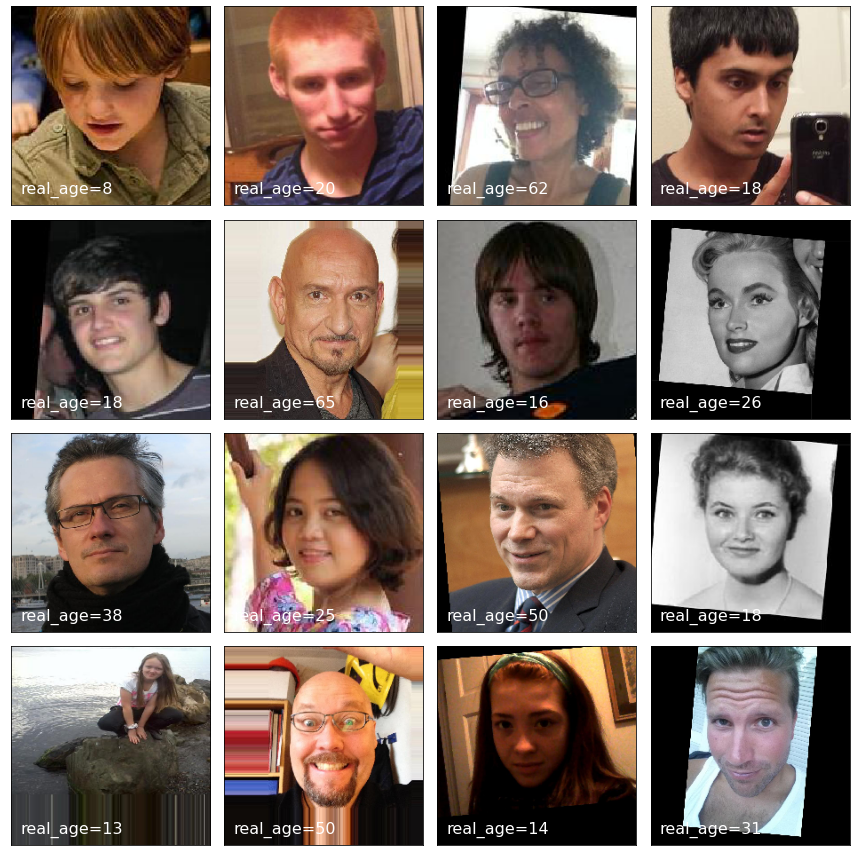

In [35]:
features, targets = next(train_gen_flow)

fig = plt.figure(figsize=(12,12))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.imshow(features[i])
    plt.text(10,210,s=f'real_age={targets[i]}', color='w', fontsize=16)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

__Наблюдения:__
В данных представлены преимущественно наиболее активные категории населения в возрасте от 10 до 40. Лиц пожилого возраста в выборке не слишком много. По фотографиям датасета можно судить, что в нем представлены преимущественно европейцы или жители Северной Америки. Сфотографированным только лица людей, все фотографии центрированы и имеют естественную вертикальную ориентацию. Лица расположены, в основном, фронтально. Часть изображений находится в рамках.  
__Выводы:__  
Так как часть возрастных категорий представлена недостаточно полно, можно предположить, что, к примеру, пожилые люди будут хуже распознаваться нейросетью. Также это относится к представителям неевропейских народов, фотографии которых в датасете не слишком много. Возможно, качество распознавания улучшилось бы если на фотографиях будут представлены не только лица, но и фигуры людей. Разнообразить датасет можно с помощью аугментации в виде небольших поворотов и сдвигов изображений, а также сменой яркости или цветовой коррекцией в них.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
 
 
optimizer = Adam(lr=0.0001)
 
def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    labels = labels.dropna()
    train_datagen = ImageDataGenerator(validation_split=0.25, 
         rescale=1./255,
         horizontal_flip=True,
         rotation_range=90,
         width_shift_range=0.2, 
         height_shift_range=0.2
         )
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    labels = labels.dropna()
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= '/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
def create_model(input_shape):
    resnet = ResNet50(input_shape=(150, 150, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
 
    model = Sequential()
    model.add(resnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=4,
                steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model
```

__Пояснения:__  
Модель обучалась на сервере _Яндекс Практикум_ на _GPU_. Ниже приведена полная распечатка логов процесса обучения. В конце выведена точность обученной нейросети.

```
2023-05-02 06:10:21.699487: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-05-02 06:10:21.701184: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-05-02 06:10:22.590341: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-05-02 06:10:22.600487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-05-02 06:10:22.600580: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-05-02 06:10:22.600624: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-02 06:10:22.602744: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-05-02 06:10:22.603243: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-05-02 06:10:22.605316: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-05-02 06:10:22.606504: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-05-02 06:10:22.606583: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-05-02 06:10:22.610436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-05-02 06:10:22.796952: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-05-02 06:10:22.803539: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-05-02 06:10:22.804180: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x46a7cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-02 06:10:22.804216: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-05-02 06:10:22.957178: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3d07fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-02 06:10:22.957215: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-05-02 06:10:22.959250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-05-02 06:10:22.959311: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-05-02 06:10:22.959323: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-02 06:10:22.959349: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-05-02 06:10:22.959359: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-05-02 06:10:22.959368: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-05-02 06:10:22.959377: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-05-02 06:10:22.959384: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-05-02 06:10:22.963058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-05-02 06:10:22.963118: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-05-02 06:10:23.381106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-05-02 06:10:23.381156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-05-02 06:10:23.381164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-05-02 06:10:23.384902: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-05-02 06:10:23.384950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/4
2023-05-02 06:10:34.638577: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-02 06:10:34.996788: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 111s - loss: 253.2654 - mae: 11.8540 - val_loss: 369.3346 - val_mae: 14.3652
Epoch 2/4
356/356 - 104s - loss: 137.8777 - mae: 8.8911 - val_loss: 330.2513 - val_mae: 13.0227
Epoch 3/4
356/356 - 103s - loss: 123.0483 - mae: 8.4625 - val_loss: 94.3546 - val_mae: 7.3404
Epoch 4/4
356/356 - 105s - loss: 111.0464 - mae: 8.1064 - val_loss: 99.9022 - val_mae: 7.4845
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 99.9022 - mae: 7.4845
Test MAE: 7.4845

```

## Анализ обученной модели

Для основы построения нейросети в проекте была выбрана сверточная сеть ResNet50, особенностью которой является наличие слоев типа _skip connections_ и присутствие полносвязного слоя лишь на выходе. Сеть была предобучена, ее стандартный выходной слой заменен слоем из одного нейрона с линейной активацией для случая с регрессионной задачей. К исходным изображениям была применена аугментация в виде горизонтального отражения поворотов до 90 гр. и небольших сдвигов по вертикали и горизонтали. Для обучения нейросети был применен алгоритм оптимизации _ADAM_ c начальным значением `learning_rate=0.0001`. За 4 эпохи обучения сеть сумела добиться требуемого уровня точности _MAE < 8_ (а именно, 7.4845) и здесь верно подобранный `learning_rate` сыграл наиболее существенную роль.